In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys


In [2]:
sys.path.append(str(Path("..") / "03_src"))


In [3]:
import utils

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns', None)


In [4]:
orders_enriched = pd.read_csv(
    utils.path() + "\\03_curated\\orders_enriched.csv"
)


In [5]:
# Aggregate seller-level KPIs
seller_kpis = (
    orders_enriched.groupby("seller_id").agg(
        order_volume=('order_id','count'),
        avg_processing_time=('processing_time','mean'),
        avg_shipping_time=('shipping_time','mean'),
        avg_delivery_time=('delivery_time','mean'),
        late_shipping_count=('late_shipping_flag','sum'),
        extreme_shipping_count=('extreme_delivery_flag','sum')
    ).reset_index()
)

seller_kpis['late_shipping_rate'] = seller_kpis['late_shipping_count'] / seller_kpis['order_volume']
seller_kpis['extreme_shipping_rate'] = seller_kpis['extreme_shipping_count'] / seller_kpis['order_volume']


In [6]:
# Aggregate regional KPIs
regional_kpis = (
    orders_enriched.groupby('customer_state')
    .agg(order_volume=('order_id','count'),
         avg_delivery_time=('delivery_time','mean'),
         late_delivery_count=('late_delivery_flag','sum'))
    .reset_index()
)
regional_kpis['late_delivery_rate'] = regional_kpis['late_delivery_count'] / regional_kpis['order_volume']


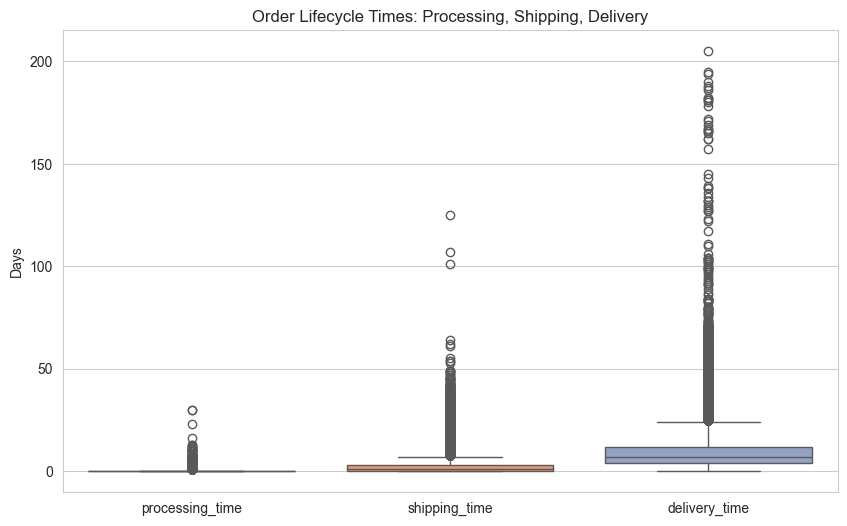

C:\Users\acer\AppData\Local\Temp\ipykernel_13736\2355408593.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variable', y='value',


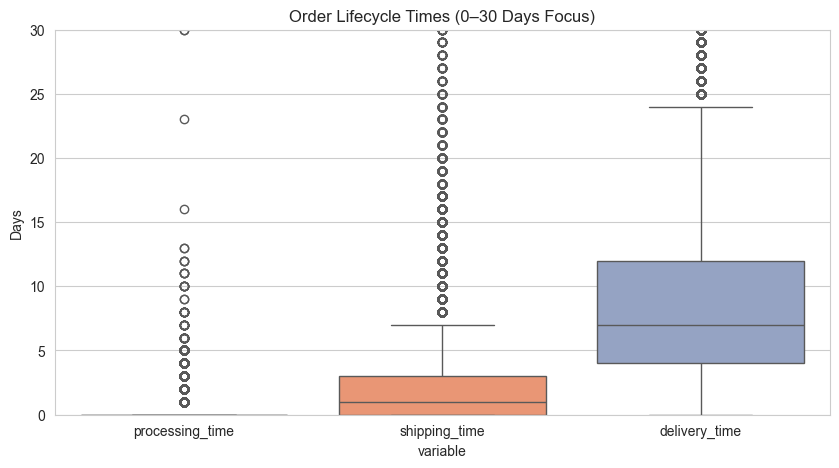

In [7]:
# -------------------------------
# SECTION 1: Order Lifecycle Distributions
# -------------------------------

plt.figure(figsize=(10,6))
sns.boxplot(data=orders_enriched[['processing_time','shipping_time','delivery_time']], palette='Set2')
plt.title("Order Lifecycle Times: Processing, Shipping, Delivery")
plt.ylabel("Days")
plt.show()

# Focus on relevant range (0-30 days) to highlight operational delays
plt.figure(figsize=(10,5))
sns.boxplot(x='variable', y='value',
            data=pd.melt(orders_enriched[['processing_time','shipping_time','delivery_time']]),
            palette='Set2')
plt.ylim(0,30)
plt.title("Order Lifecycle Times (0–30 Days Focus)")
plt.ylabel("Days")
plt.show()


1. Order Lifecycle Boxplots (All Orders & 0–30 Days Focus)

Takeaway:

- Most orders are processed almost instantly (median ~0 days).
- Shipping is the main contributor to delays (median ~1 day, but long tail up to 125 days).
- Delivery shows high variability (median ~7 days, max >200 days).

**Interpretation**:
Operational interventions should focus on shipping times; processing delays are negligible.

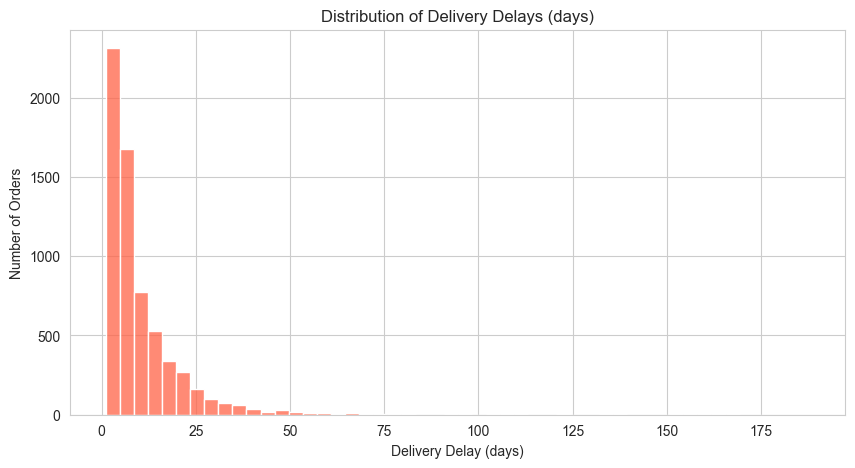

In [8]:
# -------------------------------
# SECTION 2: Delivery Delay Distribution
# -------------------------------

delayed_orders = orders_enriched[orders_enriched['delivery_delay'] > 0]

plt.figure(figsize=(10,5))
sns.histplot(delayed_orders['delivery_delay'], bins=50, color='tomato')
plt.title("Distribution of Delivery Delays (days)")
plt.xlabel("Delivery Delay (days)")
plt.ylabel("Number of Orders")
plt.show()


2. Distribution of Delivery Delays

Takeaway:
- Majority of delays are modest (<10 days), but a small number of extreme delays (>30 days) exist.

**Interpretation**:
Extreme delays are rare but critical; they should trigger immediate root-cause analysis.

C:\Users\acer\AppData\Local\Temp\ipykernel_13736\418514169.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


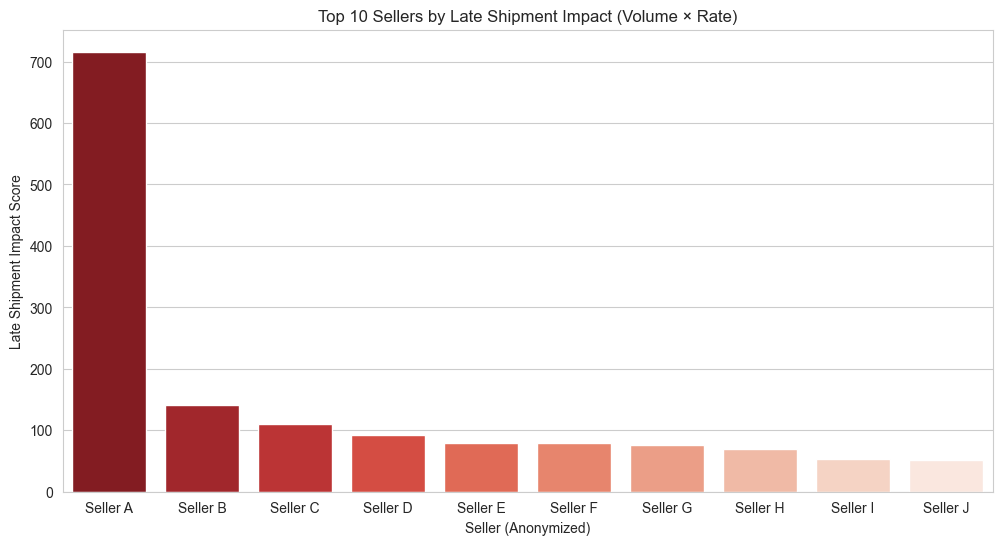

In [10]:
# -------------------------------
# SECTION 3: Top Sellers Driving Delays (Impact Analysis)
# -------------------------------

# Compute impact score
seller_kpis['impact_score'] = seller_kpis['late_shipping_rate'] * seller_kpis['order_volume']

# Top 10 sellers by impact
top_sellers = seller_kpis.sort_values('impact_score', ascending=False).head(10).copy()

# Create clean seller labels based on rank
top_sellers['seller_label'] = [
    f"Seller {chr(65+i)}" for i in range(len(top_sellers))
]

plt.figure(figsize=(12,6))
sns.barplot(
    x='seller_label',
    y='impact_score',
    data=top_sellers,
    palette='Reds_r'
)

plt.title("Top 10 Sellers by Late Shipment Impact (Volume × Rate)")
plt.ylabel("Late Shipment Impact Score")
plt.xlabel("Seller (Anonymized)")
plt.show()


3. Top 10 Sellers by Late Shipment Impact

Takeaway:

- A very small number of sellers (~0.4%) account for a disproportionate share of late shipments.
- High-volume sellers with moderate late rates can cause the largest operational impact.

**Interpretation**:
Targeted intervention on these sellers is more effective than broad enforcement.


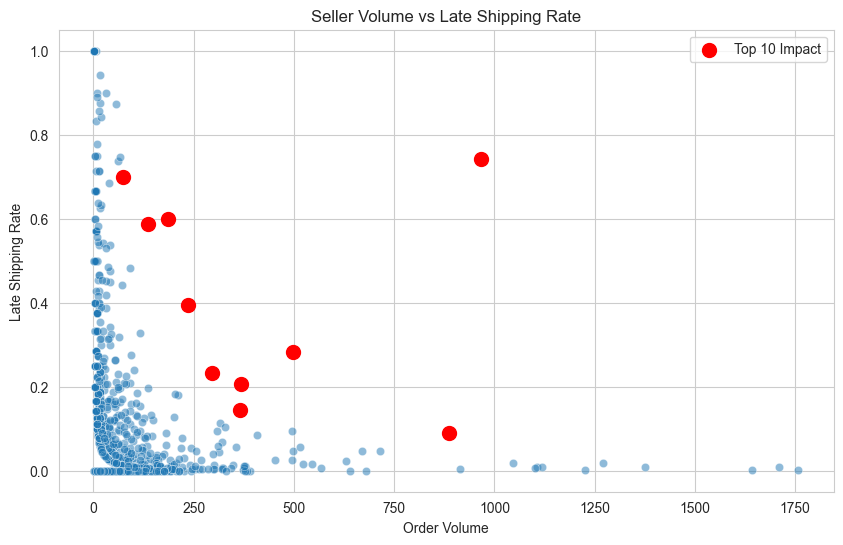

In [11]:
# -------------------------------
# SECTION 4: Volume vs Late Rate
# ------------------------------- 
plt.figure(figsize=(10,6))
sns.scatterplot(x='order_volume', y='late_shipping_rate', data=seller_kpis, alpha=0.5)
plt.scatter(top_sellers['order_volume'], top_sellers['late_shipping_rate'], color='red', s=100, label='Top 10 Impact')
plt.title("Seller Volume vs Late Shipping Rate")
plt.xlabel("Order Volume")
plt.ylabel("Late Shipping Rate")
plt.legend()
plt.show()

4. Seller Volume vs Late Shipping Rate (Scatter Plot)

Takeaway:

- Low-volume sellers can have very high per-order late rates, but their total impact is limited.
- High-volume sellers with moderate late rates contribute the most to system-wide delays.

**Interpretation**:

Prioritization must consider impact (volume × late rate), not late rate alone.

C:\Users\acer\AppData\Local\Temp\ipykernel_13736\3741386170.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_summary = seller_kpis.groupby('volume_bucket').agg(
C:\Users\acer\AppData\Local\Temp\ipykernel_13736\3741386170.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='volume_bucket', y='avg_late_shipments', data=volume_summary, palette='Blues_r')


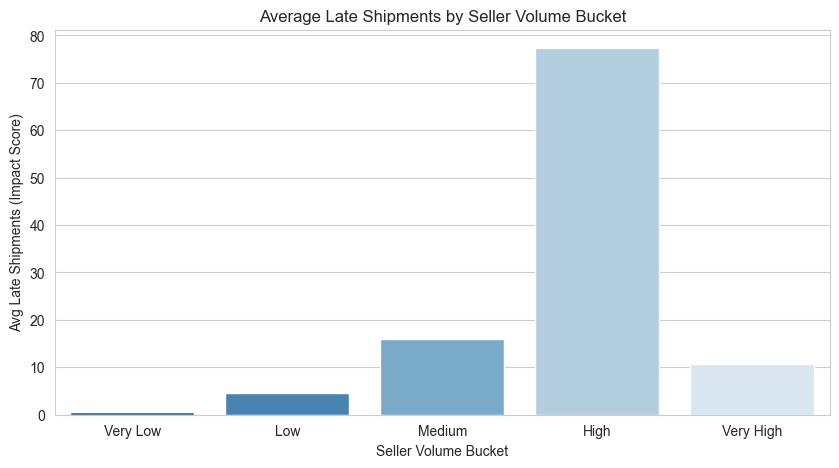

In [12]:
# -------------------------------
# SECTION 5: Volume Bucket Analysis
# -------------------------------

# Define volume buckets
seller_kpis['volume_bucket'] = pd.cut(seller_kpis['order_volume'],
                                     bins=[0,50,200,500,1000,10000],
                                     labels=['Very Low','Low','Medium','High','Very High'])

volume_summary = seller_kpis.groupby('volume_bucket').agg(
    avg_late_rate=('late_shipping_rate','mean'),
    avg_order_volume=('order_volume','mean'),
    avg_late_shipments=('impact_score','mean')
).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='volume_bucket', y='avg_late_shipments', data=volume_summary, palette='Blues_r')
plt.title("Average Late Shipments by Seller Volume Bucket")
plt.ylabel("Avg Late Shipments (Impact Score)")
plt.xlabel("Seller Volume Bucket")
plt.show()


5. Average Late Shipments by Seller Volume Bucket

Takeaway:

- “High” and “Very High” volume sellers generate significantly more late shipments in aggregate than low-volume sellers.

**Interpretation**:
Operational focus should be on high-impact, high-volume sellers, even if they have better reliability per order.

C:\Users\acer\AppData\Local\Temp\ipykernel_13736\4091427342.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_state', y='avg_delivery_time', data=regional_sorted, palette='Blues_r')


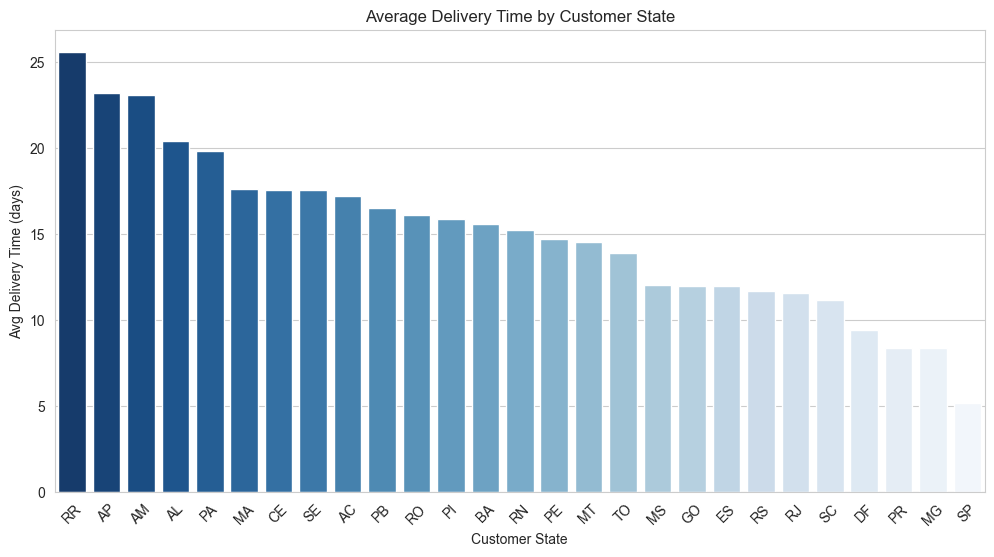

In [13]:
# -------------------------------
# SECTION 6: Regional Performance
# -------------------------------

# Average delivery time by state
regional_sorted = regional_kpis.sort_values('avg_delivery_time', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='customer_state', y='avg_delivery_time', data=regional_sorted, palette='Blues_r')
plt.xticks(rotation=45)
plt.title("Average Delivery Time by Customer State")
plt.ylabel("Avg Delivery Time (days)")
plt.xlabel("Customer State")
plt.show()




6. Average Delivery Time by Customer State

Takeaway:

- Some states consistently experience longer delivery times than others.

**Interpretation**:
Regional logistics constraints affect SLA adherence; interventions may require state-specific logistics improvements.

C:\Users\acer\AppData\Local\Temp\ipykernel_13736\3265523043.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_state', y='late_delivery_rate', data=regional_sorted, palette='Oranges_r')


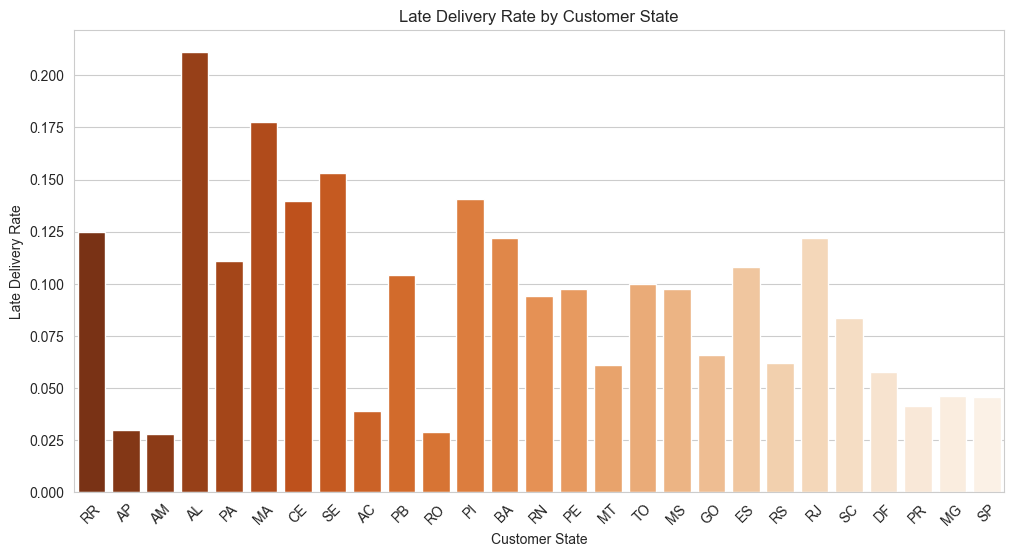

In [14]:
# -------------------------------
# SECTION 7: Late delivery rate by state
# -------------------------------
plt.figure(figsize=(12,6))
sns.barplot(x='customer_state', y='late_delivery_rate', data=regional_sorted, palette='Oranges_r')
plt.xticks(rotation=45)
plt.title("Late Delivery Rate by Customer State")
plt.ylabel("Late Delivery Rate")
plt.xlabel("Customer State")
plt.show()

7. Late Delivery Rate by Customer State

Takeaway:

- Late delivery rates mirror average delivery time, confirming regional disparities.

**Interpretation**:

Supports regional monitoring for SLA breaches and targeted interventions.

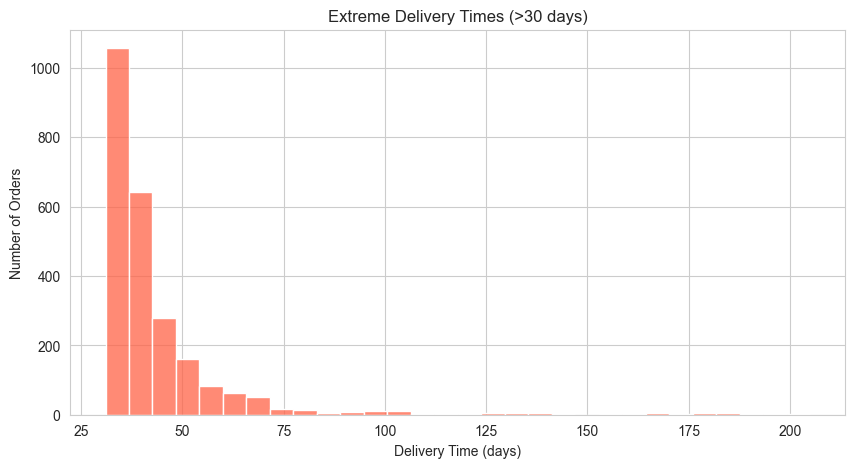

In [15]:
# -------------------------------
# SECTION 8: Extreme Delays
# -------------------------------

extreme_orders = orders_enriched[orders_enriched['extreme_delivery_flag']]

plt.figure(figsize=(10,5))
sns.histplot(extreme_orders['delivery_time'], bins=30, color='tomato')
plt.title("Extreme Delivery Times (>30 days)")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Number of Orders")
plt.show()




8. Extreme Delivery Times (>30 Days)

Takeaway:

- Extreme delivery times are heavily skewed toward a few sellers.
- Most sellers have zero or very few extreme delays.
Interpretation:
- Extreme cases represent operational failures and warrant immediate escalation.



C:\Users\acer\AppData\Local\Temp\ipykernel_13736\2990001338.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=extreme_seller_counts.index, y=extreme_seller_counts.values, palette='Reds_r')


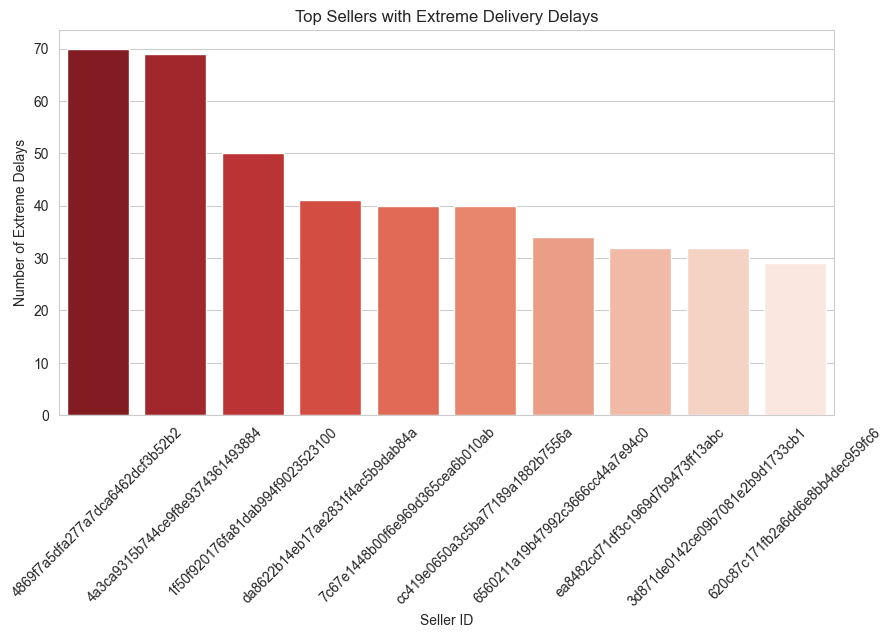

In [16]:
# -------------------------------
# SECTION 9: Highlight top sellers causing extreme delays
# -------------------------------
extreme_seller_counts = extreme_orders['seller_id'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=extreme_seller_counts.index, y=extreme_seller_counts.values, palette='Reds_r')
plt.xticks(rotation=45)
plt.title("Top Sellers with Extreme Delivery Delays")
plt.ylabel("Number of Extreme Delays")
plt.xlabel("Seller ID")
plt.show()

9. Top Sellers Causing Extreme Delivery Delays

Takeaway:

- A small subset of sellers disproportionately causes extreme delays.

**Interpretation**:

Seller-level escalation and remediation should focus on this tiny subset for maximum impact.

In [17]:
# -------------------------------
# END OF NOTEBOOK
# -------------------------------
